<a href="https://colab.research.google.com/github/varunreddyGOPU/AI-_Image_Generation-for-Product-Marketing/blob/main/Image_gen_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google import genai
from google.genai import types
from PIL import Image
from io import BytesIO

# Initialize the client with your API key
from google.colab import userdata

GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')
client = genai.Client(api_key=GEMINI_API_KEY)

# Define your prompt
prompt = "image of fruits and milk with safeway logo"

# Generate the image
response = client.models.generate_images(
    model='imagen-3.0-generate-002',
    prompt=prompt,
    config=types.GenerateImagesConfig(number_of_images=1)
)

for generated_image in response.generated_images:
    # Get the generated image
    image = Image.open(BytesIO(generated_image.image.image_bytes))

    # Open the logo you want to add (make sure it's in your working directory)
    logo = Image.open("/content/sample_data/albertsons-logo-1.png")
    # Resize the logo if needed (example: set width to 100px, keep aspect ratio)
    logo_width = 100
    logo_height = int(logo.height * (logo_width / logo.width))
    logo = logo.resize((logo_width, logo_height))

    # Paste the logo onto the generated image (adjust x, y position as needed)
    image.paste(logo, (image.width - logo.width - 10, image.height - logo.height - 10), logo)

    # Show the image (may not work in all environments)
    image.show()
    # Save the image with the logo
    image.save("output2_with_logo.png")

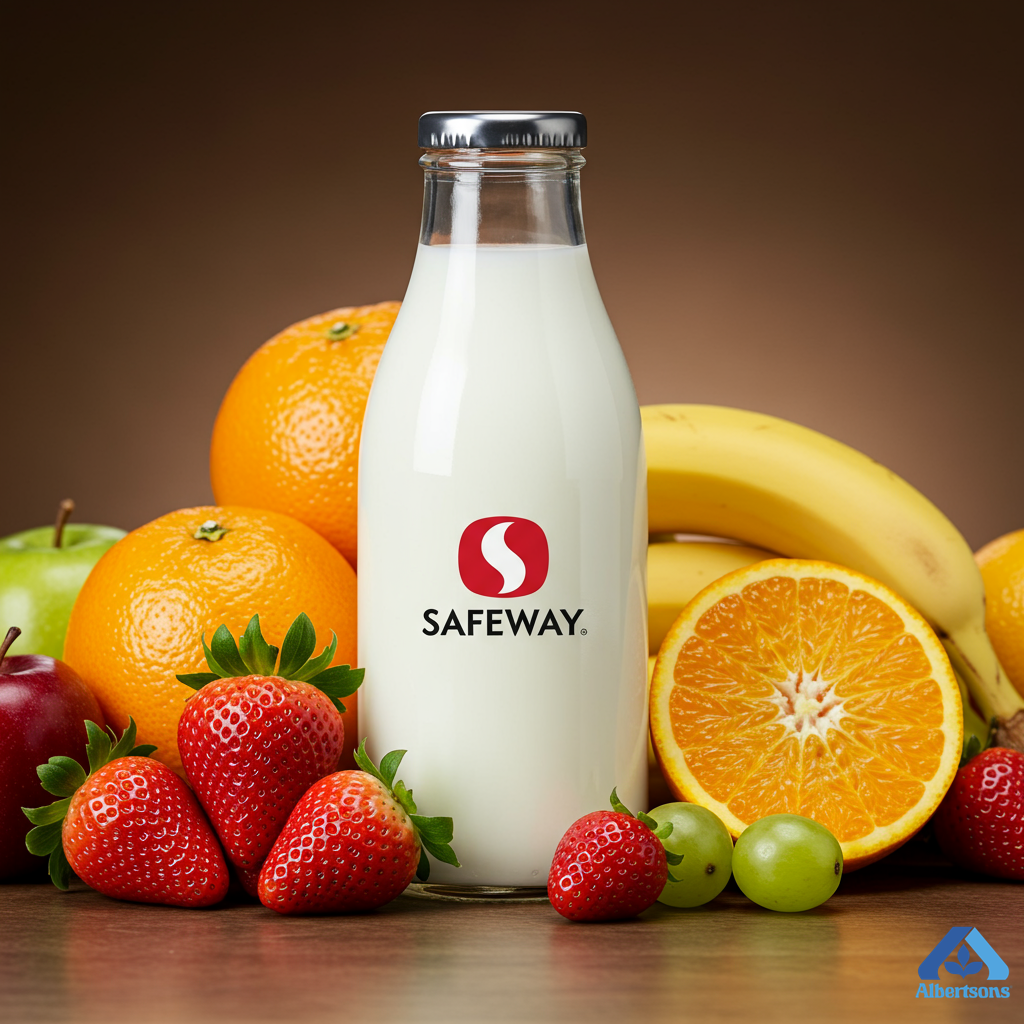

In [19]:
from IPython.display import Image
display(Image("output2_with_logo.png"))

In [33]:
import requests
from google.colab import userdata

SONAR_API_KEY = userdata.get('SONAR_API_KEY')
SONAR_API_URL = "https://api.perplexity.ai/chat/completions"

headers = {
    "Authorization": f"Bearer {SONAR_API_KEY}",
    "Content-Type": "application/json"
}

prompt = """
Give a description about eating healthy with strawberries, oranges, and bananas with milk.
Include information about the main nutrient values in these foods.
"""

data = {
    "model": "sonar-pro",
    "messages": [
        {"role": "user", "content": prompt}
    ]
}

response = requests.post(SONAR_API_URL, headers=headers, json=data)
print("Status code:", response.status_code)
print("Response text:", response.text)

with open("sonar_response.txt", "w", encoding="utf-8") as f:
    f.write(response.text)
if response.status_code == 200:
    try:
        # Check the actual response structure; may be "choices[0].message.content" or similar
        description = response.json()["choices"][0]["message"]["content"]
        print(description)
    except Exception as e:
        print("Error parsing response:", e)
else:
    print("Failed to get description:", response.text)

Status code: 200
Response text: {"id": "56aa9e40-24b2-46ba-b441-4f827d7019cf", "model": "sonar-pro", "created": 1748440635, "usage": {"prompt_tokens": 27, "completion_tokens": 552, "total_tokens": 579, "search_context_size": "low"}, "citations": ["https://www.allrecipes.com/recipe/215163/strawberry-orange-banana-smoothie/", "https://www.ambitiouskitchen.com/strawberry-orange-banana-smoothie/", "https://www.myfooddiary.com/foods/7378467/great-value-strawberry-orange-banana-drink-mix", "https://www.ewg.org/foodscores/products/043000950548-CrystalLightDrinkMixStrawberryOrangeBanana/", "https://smoothiebox.com/blogs/information/strawberry-banana-smoothie-guide"], "object": "chat.completion", "choices": [{"index": 0, "finish_reason": "stop", "message": {"role": "assistant", "content": "Eating healthy with strawberries, oranges, bananas, and milk creates a nutritional powerhouse that supports overall wellness. These ingredients combined\u2014often in the form of a smoothie\u2014offer an exce

In [34]:
!pip install jinja2


In [ ]:
from fastapi import FastAPI, Request
from fastapi.staticfiles import StaticFiles
from fastapi.responses import HTMLResponse, FileResponse
from pydantic import BaseModel
import os
import nest_asyncio
import uvicorn
from pyngrok import ngrok

# Create static directory if it doesn't exist
os.makedirs("static", exist_ok=True)

# Copy the image to static (adjust as needed)
!cp /content/output2_with_logo.png static/output2_with_logo.png

app = FastAPI()
app.mount("/static", StaticFiles(directory="static"), name="static")

class PromptRequest(BaseModel):
    prompt: str

@app.post("/get_prompt")
async def get_prompt(req: PromptRequest):
    return {"prompt": req.prompt}

@app.get("/", response_class=HTMLResponse)
async def home(request: Request):

    return f"""
    <!DOCTYPE html>
    <html>
        <head><title>Image Display</title></head>
        <body>
            <h1>Image Display</h1>
            <img src="/static/output2_with_logo.png" alt="Branded Image" width="400">
            <h2>Prompt Response</h2>
            <p>{{ response.text }}</p>
        </body>
    </html>
    """

nest_asyncio.apply()
public_url = ngrok.connect(8000)
print("Public FastAPI URL:", public_url)
uvicorn.run(app, port=8000)


In [41]:
from fastapi import FastAPI, Request
from fastapi.staticfiles import StaticFiles
from fastapi.responses import HTMLResponse
from fastapi.templating import Jinja2Templates
from pydantic import BaseModel
import os
import nest_asyncio
import uvicorn
from pyngrok import ngrok

# Create static and templates directories if they don't exist
os.makedirs("static", exist_ok=True)
os.makedirs("templates", exist_ok=True)

# Copy the image to static (adjust as needed)
!cp /content/output2_with_logo.png static/output2_with_logo.png

app = FastAPI()
app.mount("/static", StaticFiles(directory="static"), name="static")
templates = Jinja2Templates(directory="templates")

class PromptRequest(BaseModel):
    prompt: str

@app.post("/get_prompt")
async def get_prompt(req: PromptRequest):
    return {"prompt": req.prompt}

@app.get("/", response_class=HTMLResponse)
async def home(request: Request):
    # Read the response from file
    try:
        with open("/content/sonar_response.txt", "r", encoding="utf-8") as f:
            response_text = f.read()
    except FileNotFoundError:
        response_text = "No response found."
    return templates.TemplateResponse(
        "index.html",
        {"request": request, "response_text": response_text}
    )

nest_asyncio.apply()
public_url = ngrok.connect(8000)
print("Public FastAPI URL:", public_url)
uvicorn.run(app, port=8000)


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [4667]


In [42]:
from fastapi import FastAPI, Request
from fastapi.staticfiles import StaticFiles
from fastapi.responses import HTMLResponse
from fastapi.templating import Jinja2Templates
from pydantic import BaseModel
import os
import nest_asyncio
import uvicorn
from pyngrok import ngrok

# Create static and templates directories if they don't exist
os.makedirs("static", exist_ok=True)
os.makedirs("templates", exist_ok=True)

# Copy the image and CSS to static (adjust as needed)
!cp /content/output2_with_logo.png static/output2_with_logo.png

app = FastAPI()
app.mount("/static", StaticFiles(directory="static"), name="static")
templates = Jinja2Templates(directory="templates")

class PromptRequest(BaseModel):
    prompt: str

@app.post("/get_prompt")
async def get_prompt(req: PromptRequest):
    return {"prompt": req.prompt}

@app.get("/", response_class=HTMLResponse)
async def home(request: Request):
    try:
        with open("/content/sonar_response.txt", "r", encoding="utf-8") as f:
            response_text = f.read()
    except FileNotFoundError:
        response_text = "No response found."
    return templates.TemplateResponse(
        "index.html",
        {"request": request, "response_text": response_text}
    )

nest_asyncio.apply()
public_url = ngrok.connect(8000)
print("Public FastAPI URL:", public_url)
uvicorn.run(app, port=8000)


Public FastAPI URL: NgrokTunnel: "https://3977-34-16-218-83.ngrok-free.app" -> "http://localhost:8000"


INFO:     Started server process [4667]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     2601:646:a284:6c70:11bd:3e95:a9be:628:0 - "GET / HTTP/1.1" 200 OK
INFO:     2601:646:a284:6c70:11bd:3e95:a9be:628:0 - "GET /static/style.css HTTP/1.1" 200 OK
INFO:     2601:646:a284:6c70:11bd:3e95:a9be:628:0 - "GET /static/output2_with_logo.png HTTP/1.1" 200 OK
INFO:     2601:646:a284:6c70:11bd:3e95:a9be:628:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [4667]
